### **Imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Thu Feb  8 13:54:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
# import mlflow
# import mlflow.sklearn

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from struct import unpack
from tqdm import tqdm

In [6]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## **Utility Functions**

In [42]:
def eval_model_on_test(model, test_ds):

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(1000),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)
    if len(predictions[0]) > 1:
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = np.array(predictions)

    test_labels = np.array(test_labels)

    return test_labels, predictions

def plot_accuracy_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs_range = training_history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Base)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Base)')
    plt.show()

def print_layer_trainable(model):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    MAX_FILE_COUNT = 250
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    # file_list.count
    cnt = 0
    for file in file_list:
        cnt += 1
        if cnt > MAX_FILE_COUNT: #Stop creating files in the local directory if the number of files > MAX_FILE_COUNT
          break
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

def search_processed_datasets_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            search_processed_datasets_folder(file['id'], root+'/'+file['title'])
        else:
            # download_mimetype = None
            filename = '{}{}'.format(root+'/', file['title'])
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def get_folder_info(folder_id):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    print(f'Number of folders/files in folder = {len(file_list)}')
    for file in file_list:
        if file['mimeType'].split('.')[-1] == 'folder':
            print(f"Folder Name = {file['title']}")
            get_folder_info(file['id'])
        else:
            pass

def create_base_model(activation, initializer, regularizer, dropout_rate, num_start_cnn_neurons=32, num_dense_neurons=256):
    model = tf.keras.Sequential([

      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

      tf.keras.layers.Conv2D(filters=num_start_cnn_neurons, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Conv2D(filters=num_start_cnn_neurons*2, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Conv2D(filters=num_start_cnn_neurons*4, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(num_dense_neurons, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Dense(len(CLASSES), activation='softmax')

    ])
    return model

def create_restnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons=256):
    restnet_cnn_layers = tf.keras.applications.resnet50.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                include_top=False,
                                                weights='imagenet',
                                                )

    last_conv_layer = restnet_cnn_layers.get_layer('conv5_block3_out')
    # Convolutional part from the resnet model
    conv_layers = Model(inputs=restnet_cnn_layers.input, outputs=last_conv_layer.output)
    # Freeze all conv layers
    conv_layers.trainable = False

    # Start a new Keras Sequential model.
    model = tf.keras.Sequential()

    model.add(layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    # Add only the convolutional part of the RestNet50 model from above.
    model.add(conv_layers)

    # the resnet model uses a global average pooling layer before the final dense layer
    # other models may just flatten the final convolutional layer or
    # use other pooling layers so make sure to check the original model architecture
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Adding one Dense layer before the final output layer
    model.add(tf.keras.layers.Dense(num_dense_neurons, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    # Add a final dense (aka. fully-connected) layer.
    # This is for combining features recognized in the image and calculating predictions
    # note that the number of nodes is the sameas the number of classes
    model.add(tf.keras.layers.Dense(len(CLASSES), activation='softmax'))

    return model

def get_mismatches(y_true, y_pred, BATCH_SIZE):
    num_mismatches = 0
    mismatch_tensor_indexes = {}
    for i in range(len(y_true)):
      if y_true[i] != y_pred[i]:
        num_mismatches += 1
        key = (i//BATCH_SIZE)
        tensor_index = (i % BATCH_SIZE)
        if mismatch_tensor_indexes.get(key) is not None:
          mismatch_tensor_indexes[key].append((tensor_index, i))
        else:
          mismatch_tensor_indexes[key] = [(tensor_index, i)]
    return num_mismatches, mismatch_tensor_indexes

def show_mismatches(test_ds, mismatch_tensor_indexes, num_mismatches):
    i=0
    total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
    tensor_batch = 0
    plt.figure(figsize=(15, (math.ceil(num_mismatches/30)*20)))
    for images, labels in test_ds.take(total_tensor_batches):
      if mismatch_tensor_indexes.get(tensor_batch) is not None:
        for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
          ax = plt.subplot(math.ceil(num_mismatches/4), 4, i + 1)
          plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
          plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
          plt.axis("off")
          i += 1
      tensor_batch += 1


##**Step 0: If you have already created the Train, Validation and Test datasets and stored it in GDrive then you can skip Steps 1 and 2 (otherwise skip Step 0 and go to Step 1)**

In [7]:
# If the Tensor Dataset have already been created and are available in a Google drive,
# then you do not need to run the image loads and split the data into train, validation and test.
# You can directly load the tensor datasets from the  google drive to your local environment and use it

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
processed_datasets_folder_id = '1HPhX4Pk72yYeqB1l3NK46d69GblH4EkE'
bags_folder_id = ''
schuhe_folder_id = ''
waesche_folder_id = ''

root = './data/processed/schuhe'

if not os.path.isdir("./data"):
  os.mkdir('./data')

if not os.path.isdir("./data/processed"):
  os.mkdir('./data/processed')

if not os.path.isdir("./data/processed/schuhe"):
  os.mkdir('./data/processed/schuhe')

search_processed_datasets_folder(processed_datasets_folder_id, root)
f.close()

In [8]:
PRODUCT_CATEGORY = 'schuhe'
GDRIVE_FOLDER = 'MyDrive/Best_Secret/data/processed'

IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_SIZE = (427, 350)
IMG_SHAPE = (427, 350, 3)
BATCH_SIZE = 32
CLASSES = ['schuhe_0_overall_to_right'
           , 'schuhe_1_back'
           , 'schuhe_2_top_or_soul'
           , 'schuhe_3_side_to_left'
           , 'schuhe_4_zoom'
           ]

train_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/train_dataset')
val_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/val_dataset')
test_ds = tf.data.Dataset.load(f'./data/processed/{PRODUCT_CATEGORY}/test_dataset')

# train_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/train_dataset')
# val_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/val_dataset')
# test_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/test_dataset')



In [9]:
def df_from_json(json_path, image_path):
  tdf = pd.read_json(json_path, orient='index')
  tdf['image_name'] = tdf['image_path'] + '/' + tdf['image_name']
  tdf['species'] = tdf['genus'] + '_' + tdf['specific_epithet']

  image_path = os.path.join(image_path, '')
  list_image_paths = glob.glob(image_path+'*/*.JPG')
  list_image_paths = [x.replace(image_path,'') for x in list_image_paths]
  check_image_bool = tdf['image_name'].apply(lambda x: x in list_image_paths)
  tdf = tdf[check_image_bool]

  print('loaded {}.json with shape {}'.format(json_path, tdf.shape))
  return tdf

In [10]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Train:
schuhe_0_overall_to_right occurs 155 times
schuhe_1_back occurs 166 times
schuhe_2_top_or_soul occurs 154 times
schuhe_3_side_to_left occurs 159 times
schuhe_4_zoom occurs 134 times


In [11]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Validation:
schuhe_0_overall_to_right occurs 44 times
schuhe_1_back occurs 44 times
schuhe_2_top_or_soul occurs 54 times
schuhe_3_side_to_left occurs 45 times
schuhe_4_zoom occurs 69 times


In [12]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Test:
schuhe_0_overall_to_right occurs 49 times
schuhe_1_back occurs 35 times
schuhe_2_top_or_soul occurs 46 times
schuhe_3_side_to_left occurs 45 times
schuhe_4_zoom occurs 51 times


In [13]:
train_classes, train_class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)

val_classes, val_class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)

test_classes, test_class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)

# Print summary table
print("| Class                          | Train | Validation | Test |")
print("|------------------------------  |-------|------------|------|")
for class_id in range(len(train_classes)):
    class_name = CLASSES[train_classes[class_id]]
    train_count = train_class_count[class_id]
    val_count = val_class_count[class_id]
    test_count = test_class_count[class_id]
    print(f"| {class_name:<30} | {train_count:<5} | {val_count:<10} | {test_count:<4} |")

| Class                          | Train | Validation | Test |
|------------------------------  |-------|------------|------|
| schuhe_0_overall_to_right      | 155   | 44         | 49   |
| schuhe_1_back                  | 166   | 44         | 35   |
| schuhe_2_top_or_soul           | 154   | 54         | 46   |
| schuhe_3_side_to_left          | 159   | 45         | 45   |
| schuhe_4_zoom                  | 134   | 69         | 51   |


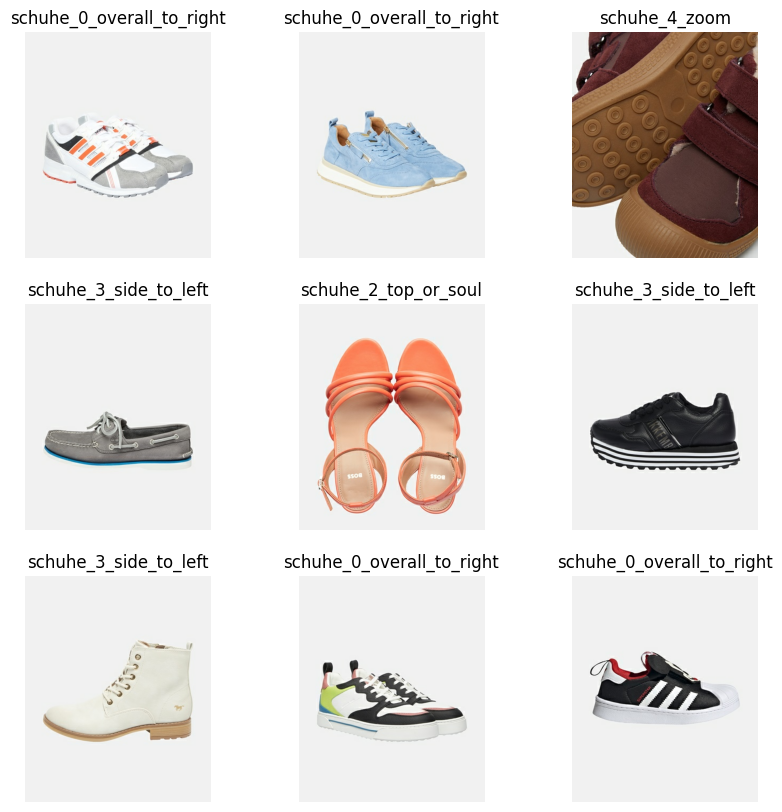

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(2):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

## **Step 1: Importing the Image data from Google drive**
see other notebooks..

##**Step 2: Load image data and split them into Train, Validation and Test**
see other notebooks..

## **Step 3: Create and train the base CNN model**


In [ ]:
# The caching helps speed up training after the first batch as the data is pulled from the cache for subsequent batches
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def create_base_model():
    model = tf.keras.Sequential([

      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),

      tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(256, activation='relu'),

      tf.keras.layers.Dense(len(CLASSES), activation='softmax')

    ])
    return model

## Compile the model

In [ ]:
model_CNNbase = create_base_model()
model_CNNbase.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [ ]:
model_CNNbase.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 427, 350, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 427, 350, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 213, 175, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 175, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 106, 87, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 106, 87, 128)      7

## Train the model

In [ ]:
history_base = model_CNNbase.fit(
    x=train_ds,
    batch_size=BATCH_SIZE,
    epochs=10,
    verbose="auto",
    # callbacks=None,
    # validation_split=0.3,
    # shuffle=True,
    validation_data=val_ds
    # class_weight=None,
    # sample_weight=None,
    # initial_epoch=0,
    # steps_per_epoch=None,
    # validation_steps=None,
    # validation_batch_size=None,
    # validation_freq=1,
)

Epoch 1/10
24/24 [==============================] - 15s 220ms/step - loss: 1.4810 - accuracy: 0.4375 - val_loss: 1.0260 - val_accuracy: 0.5977
Epoch 2/10
24/24 [==============================] - 4s 165ms/step - loss: 0.7162 - accuracy: 0.7930 - val_loss: 0.5570 - val_accuracy: 0.7930
Epoch 3/10
24/24 [==============================] - 4s 169ms/step - loss: 0.3911 - accuracy: 0.8997 - val_loss: 0.3305 - val_accuracy: 0.8945
Epoch 4/10
24/24 [==============================] - 4s 163ms/step - loss: 0.2847 - accuracy: 0.9167 - val_loss: 0.3220 - val_accuracy: 0.8867
Epoch 5/10
24/24 [==============================] - 4s 166ms/step - loss: 0.1737 - accuracy: 0.9466 - val_loss: 0.2606 - val_accuracy: 0.9062
Epoch 6/10
24/24 [==============================] - 4s 164ms/step - loss: 0.1257 - accuracy: 0.9622 - val_loss: 0.2539 - val_accuracy: 0.9102
Epoch 7/10
24/24 [==============================] - 4s 163ms/step - loss: 0.0911 - accuracy: 0.9714 - val_loss: 0.2444 - val_accuracy: 0.9219
Epoch

## Model evaluation and Visualize training results
Create plots of loss and accuracy on the training and validation sets.

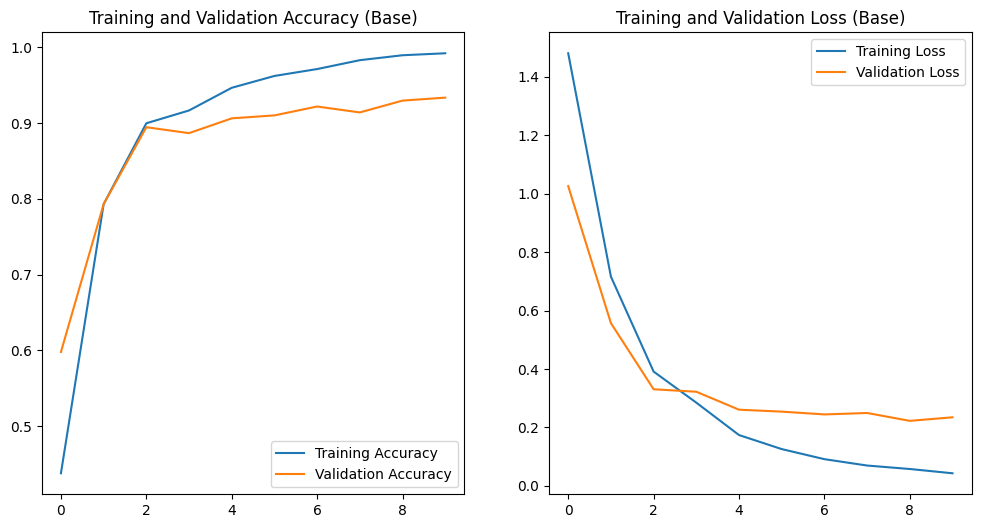

In [ ]:
plot_accuracy_loss(history_base)

In [ ]:
y_true, y_pred = eval_model_on_test(model_CNNbase, test_ds)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 274ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

1/1 [==============================] - 0s 124ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:00<00:02,  2.83it/s]

1/1 [==============================] - 0s 110ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:00<00:01,  3.33it/s]

1/1 [==============================] - 0s 141ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:01<00:01,  3.59it/s]

1/1 [==============================] - 0s 69ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:01<00:00,  4.00it/s]

1/1 [==============================] - 0s 70ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:01<00:00,  4.29it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:01<00:00,  4.87it/s]

1/1 [==============================] - 0s 471ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


In [ ]:
print("Accuracy of base model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of base model on test data: 94.69%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.98      0.96      0.97        49
            schuhe_1_back       0.87      0.94      0.90        35
     schuhe_2_top_or_soul       0.98      0.91      0.94        46
    schuhe_3_side_to_left       0.91      0.96      0.93        45
            schuhe_4_zoom       0.98      0.96      0.97        51

                 accuracy                           0.95       226
                macro avg       0.94      0.95      0.94       226
             weighted avg       0.95      0.95      0.95       226



,0,1,2,3,4
0,47,2,0,0,0
1,0,33,0,2,0
2,0,2,42,1,1
3,1,0,1,43,0
4,0,1,0,1,49


## Transfer learning - ResNet50 without Tuning

In [19]:
model_resnet_base = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

94765736/94765736 [==============================] - 5s 0us/step


In [20]:
for layer in model_resnet_base.layers[-5:]:
  print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


In [21]:
# SHARED PARAMETER
# Number of classes
num_classes = 5

In [22]:
# Sequential model creation:

# Make the base resnet model
# Points to last layer
last_conv_layer = model_resnet_base.get_layer('conv5_block3_out')
# Convolutional part from the resnet model
conv_model = Model(inputs=model_resnet_base.input, outputs=last_conv_layer.output)
# Freeze all conv layers
conv_model.trainable = False

In [23]:
# Start a new Keras Sequential model
model_resnet = Sequential()

# Add a Lambda layer to apply preprocess_input of resnet model
model_resnet.add(layers.Lambda(tf.keras.applications.resnet.preprocess_input, input_shape=IMG_SHAPE))

# Add the convolutional part of the model from above
model_resnet.add(conv_model)

# The resnet model uses a global average pooling layer before the final dense layer
# other models may just flatten the final convolutional layer or
# use other pooling layers so make sure to check the original model architecture
model_resnet.add(tf.keras.layers.GlobalAveragePooling2D())

# TODO try additional dense layer with 256 nodes
# TODO try dropout with 0.2 rate

# Add a final dense (aka. fully-connected) layer
# This is for combining features recognized in the image and calculating predictions
# note that the number of nodes is the same as the number of classes
model_resnet.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [24]:
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 427, 350, 3)       0         
                                                                 
 model (Functional)          (None, 14, 11, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [25]:
for layer in model_resnet_base.layers:
    print(layer.name, '->', layer.trainable)

input_1 -> False
conv1_pad -> False
conv1_conv -> False
conv1_bn -> False
conv1_relu -> False
pool1_pad -> False
pool1_pool -> False
conv2_block1_1_conv -> False
conv2_block1_1_bn -> False
conv2_block1_1_relu -> False
conv2_block1_2_conv -> False
conv2_block1_2_bn -> False
conv2_block1_2_relu -> False
conv2_block1_0_conv -> False
conv2_block1_3_conv -> False
conv2_block1_0_bn -> False
conv2_block1_3_bn -> False
conv2_block1_add -> False
conv2_block1_out -> False
conv2_block2_1_conv -> False
conv2_block2_1_bn -> False
conv2_block2_1_relu -> False
conv2_block2_2_conv -> False
conv2_block2_2_bn -> False
conv2_block2_2_relu -> False
conv2_block2_3_conv -> False
conv2_block2_3_bn -> False
conv2_block2_add -> False
conv2_block2_out -> False
conv2_block3_1_conv -> False
conv2_block3_1_bn -> False
conv2_block3_1_relu -> False
conv2_block3_2_conv -> False
conv2_block3_2_bn -> False
conv2_block3_2_relu -> False
conv2_block3_3_conv -> False
conv2_block3_3_bn -> False
conv2_block3_add -> False
con

In [26]:
# SHARED PARAMETERS
# Optimizer, learning rate, loss and metrics
learning_rate = 1e-5
optimizer = Adam(learning_rate=learning_rate) # TODO try SGD with Momentum and dynamic learning rate
loss = 'sparse_categorical_crossentropy'
metrics_monitor = ['accuracy']

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)

# Default number of epochs
epochs = 40

In [27]:
model_resnet.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

history_resnet = model_resnet.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        callbacks = [early_stopping_cb]
                        )

Epoch 1/40
24/24 [==============================] - 28s 463ms/step - loss: 2.1072 - accuracy: 0.1536 - val_loss: 1.9564 - val_accuracy: 0.1875
Epoch 2/40
24/24 [==============================] - 10s 398ms/step - loss: 2.0567 - accuracy: 0.1562 - val_loss: 1.9155 - val_accuracy: 0.1953
Epoch 3/40
24/24 [==============================] - 10s 414ms/step - loss: 2.0109 - accuracy: 0.1602 - val_loss: 1.8779 - val_accuracy: 0.2070
Epoch 4/40
24/24 [==============================] - 10s 411ms/step - loss: 1.9684 - accuracy: 0.1667 - val_loss: 1.8425 - val_accuracy: 0.2266
Epoch 5/40
24/24 [==============================] - 10s 402ms/step - loss: 1.9285 - accuracy: 0.1654 - val_loss: 1.8089 - val_accuracy: 0.2344
Epoch 6/40
24/24 [==============================] - 10s 405ms/step - loss: 1.8907 - accuracy: 0.1745 - val_loss: 1.7763 - val_accuracy: 0.2266
Epoch 7/40
24/24 [==============================] - 10s 402ms/step - loss: 1.8543 - accuracy: 0.1823 - val_loss: 1.7447 - val_accuracy: 0.2461

In [28]:
y_true, y_pred = eval_model_on_test(model_resnet, test_ds)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:13,  1.98s/it]

1/1 [==============================] - 0s 128ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:02<00:06,  1.09s/it]

1/1 [==============================] - 0s 169ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:04,  1.22it/s]

1/1 [==============================] - 0s 86ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:03<00:02,  1.53it/s]

1/1 [==============================] - 0s 86ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:03<00:01,  1.80it/s]

1/1 [==============================] - 0s 88ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:04<00:00,  2.00it/s]

1/1 [==============================] - 0s 83ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:04<00:00,  2.17it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


In [29]:
print("Accuracy of ResNet50 on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of ResNet50 on test data: 65.04%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.47      0.57      0.51        49
            schuhe_1_back       0.62      0.74      0.68        35
     schuhe_2_top_or_soul       0.81      0.76      0.79        46
    schuhe_3_side_to_left       0.37      0.29      0.33        45
            schuhe_4_zoom       0.98      0.88      0.93        51

                 accuracy                           0.65       226
                macro avg       0.65      0.65      0.65       226
             weighted avg       0.66      0.65      0.65       226



,0,1,2,3,4
0,28,4,2,15,0
1,3,26,4,2,0
2,4,4,35,3,0
3,21,8,2,13,1
4,4,0,0,2,45


In [30]:
#model_resnet.save('model_resnet.keras')

## ResNet Fine-Tuning: Unlocking layers for training
Open some layers in the convolution layer, ( not same make layer5 of the RestNet model trainable)

In [31]:
# if use sequential model creation:
conv_model.trainable = True
for layer in conv_model.layers:
# if use functional model creation:
#model_resnet_base.trainable = True
#for layer in model_resnet_base.layers:
    if('conv5' not in layer.name):
        layer.trainable = False
    if('bn' in layer.name):
        layer.trainable = False
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [32]:
model_resnet_ft = Sequential()
model_resnet_ft.add(layers.Lambda(tf.keras.applications.resnet.preprocess_input, input_shape=IMG_SHAPE))
model_resnet_ft.add(conv_model)
model_resnet_ft.add(tf.keras.layers.GlobalAveragePooling2D())
# TODO try additional dense layer with 256 nodes
# TODO try dropout with 0.2 rate
model_resnet_ft.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_resnet_ft.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 427, 350, 3)       0         
                                                                 
 model (Functional)          (None, 14, 11, 2048)      23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 14963717 (57.08 MB)
Non-trainable params: 8634240 (32.94 MB)
_________________________________________________________________


In [33]:
#model_resnet_ft.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

# If the following error occurs when calling the fit() method, run these lines of code instead:
#KeyError: 'The optimizer cannot recognize variable conv5_block1_1_conv/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately.
#Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'
# Get the list of trainable variables
#trainable_vars = model_resnet_ft.trainable_variables

# Manually build the optimizer with the list of trainable variables
#model_resnet_ft.optimizer.build(trainable_vars)

# If it doesn't help:
from tensorflow.keras.optimizers.legacy import Adam as Adam_l
optimizer = Adam_l(learning_rate=learning_rate)
model_resnet_ft.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

In [34]:
history_resnet_ft = model_resnet_ft.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        callbacks = [early_stopping_cb]
                        )

Epoch 1/40
24/24 [==============================] - 19s 538ms/step - loss: 1.2404 - accuracy: 0.5664 - val_loss: 0.7486 - val_accuracy: 0.7891
Epoch 2/40
24/24 [==============================] - 12s 491ms/step - loss: 0.4961 - accuracy: 0.8581 - val_loss: 0.4347 - val_accuracy: 0.8359
Epoch 3/40
24/24 [==============================] - 12s 480ms/step - loss: 0.2414 - accuracy: 0.9375 - val_loss: 0.2813 - val_accuracy: 0.9062
Epoch 4/40
24/24 [==============================] - 12s 484ms/step - loss: 0.1181 - accuracy: 0.9701 - val_loss: 0.2433 - val_accuracy: 0.9102
Epoch 5/40
24/24 [==============================] - 11s 477ms/step - loss: 0.0628 - accuracy: 0.9883 - val_loss: 0.2476 - val_accuracy: 0.9023
Epoch 6/40
24/24 [==============================] - 11s 477ms/step - loss: 0.0340 - accuracy: 0.9948 - val_loss: 0.2763 - val_accuracy: 0.9062
Epoch 7/40
24/24 [==============================] - 11s 474ms/step - loss: 0.0210 - accuracy: 0.9987 - val_loss: 0.2670 - val_accuracy: 0.9180

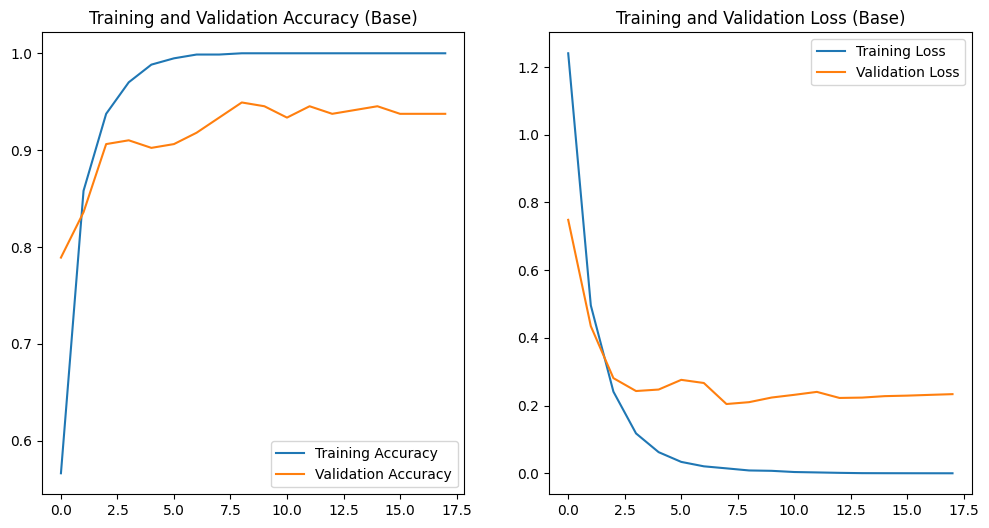

In [35]:
plot_accuracy_loss(history_resnet_ft)

In [36]:
y_true, y_pred = eval_model_on_test(model_resnet_ft, test_ds)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:13,  1.92s/it]

1/1 [==============================] - 0s 144ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:02<00:06,  1.06s/it]

1/1 [==============================] - 0s 122ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:03,  1.28it/s]

1/1 [==============================] - 0s 83ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:03<00:02,  1.60it/s]

1/1 [==============================] - 0s 83ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:03<00:01,  1.86it/s]

1/1 [==============================] - 0s 82ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:04<00:01,  1.69it/s]

1/1 [==============================] - 0s 83ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:04<00:00,  1.91it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


In [37]:
print("Accuracy of ResNet50_ft model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of ResNet50_ft model on test data: 96.02%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.96      0.94      0.95        49
            schuhe_1_back       1.00      0.94      0.97        35
     schuhe_2_top_or_soul       0.98      0.96      0.97        46
    schuhe_3_side_to_left       0.92      0.98      0.95        45
            schuhe_4_zoom       0.96      0.98      0.97        51

                 accuracy                           0.96       226
                macro avg       0.96      0.96      0.96       226
             weighted avg       0.96      0.96      0.96       226



,0,1,2,3,4
0,46,0,0,2,1
1,2,33,0,0,0
2,0,0,44,1,1
3,0,0,1,44,0
4,0,0,0,1,50


In [ ]:
#model_resnet_ft.save('schuhe_model_resnet_ft.keras')

In [63]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_model_resnet_ft.h5", save_best_only=True)

history_base = model_resnet_ft.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=epochs,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds)

Epoch 1/40
24/24 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9948

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 13s 541ms/step - loss: 0.0214 - accuracy: 0.9948 - val_loss: 0.2237 - val_accuracy: 0.9375
Epoch 2/40
24/24 [==============================] - 12s 482ms/step - loss: 0.0197 - accuracy: 0.9935 - val_loss: 0.2719 - val_accuracy: 0.9141
Epoch 3/40
24/24 [==============================] - 12s 520ms/step - loss: 0.0207 - accuracy: 0.9974 - val_loss: 0.2030 - val_accuracy: 0.9297
Epoch 4/40
24/24 [==============================] - 16s 675ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.1904 - val_accuracy: 0.9492
Epoch 5/40
24/24 [==============================] - 11s 469ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1990 - val_accuracy: 0.9492
Epoch 6/40
24/24 [==============================] - 12s 484ms/step - loss: 6.9319e-04 - accuracy: 1.0000 - val_loss: 0.2008 - val_accuracy: 0.9531
Epoch 7/40
24/24 [==============================] - 12s 490ms/step - loss: 5.2001e-04 - accuracy: 1.0000 - val_loss: 0.2032 - val_accuracy: 0.9531
Ep

###Get mismatches

In [ ]:
def get_mismatches():
  num_mismatches = 0
  mismatch_tensor_indexes = {}
  for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
      num_mismatches += 1
      key = ((i+1)//BATCH_SIZE)
      tensor_index = (i % BATCH_SIZE)
      if mismatch_tensor_indexes.get(key) is not None:
        mismatch_tensor_indexes[key].append((tensor_index, i))
      else:
        mismatch_tensor_indexes[key] = [(tensor_index, i)]
  return num_mismatches, mismatch_tensor_indexes

In [ ]:
num_mismatches, mismatch_tensor_indexes = get_mismatches()
print(f"Number of mismatches = {num_mismatches}")
mismatch_tensor_indexes

Number of mismatches = 7


{0: [(1, 1), (4, 4)],
 1: [(17, 49)],
 2: [(5, 69), (7, 71)],
 3: [(23, 119), (27, 123)]}

In [ ]:
print(f'Test data image count = {len(y_true)}\n') # Returned from eval_model_on_test(model_base, test_ds) function

i=0
for images, labels in test_ds.take(8):
  print(i, len(labels))
  print(labels)
  i += 1

# With 247 images in test and batch size of 32, the last tensor labels should only have 23 labels (i.e. 7*32 + 23 = 247)
# Why do we have 32 labels in the last Tensor??? That would mean we have 8*32 = 256 images which is not the case!!!

Test data image count = 226

0 32
tf.Tensor([4 0 4 2 2 4 2 1 0 0 3 3 4 0 4 3 0 1 4 2 2 2 1 0 4 2 3 4 4 4 3 3], shape=(32,), dtype=int32)
1 32
tf.Tensor([0 0 4 3 2 3 3 0 0 3 1 1 4 2 2 3 0 3 0 3 0 2 1 4 4 2 3 4 0 3 0 0], shape=(32,), dtype=int32)
2 32
tf.Tensor([2 3 4 3 0 2 0 0 1 3 2 2 1 2 1 4 0 1 4 1 2 3 1 1 2 0 1 1 1 4 0 3], shape=(32,), dtype=int32)
3 32
tf.Tensor([1 3 2 3 1 2 4 2 3 3 2 1 0 2 0 0 0 0 2 3 1 1 2 4 2 1 3 2 2 3 3 3], shape=(32,), dtype=int32)
4 32
tf.Tensor([4 3 4 1 4 0 3 0 2 1 2 3 4 0 4 0 4 0 3 4 2 3 3 1 4 0 1 0 1 1 3 4], shape=(32,), dtype=int32)
5 32
tf.Tensor([0 2 0 4 4 0 0 1 0 4 4 4 2 0 4 4 2 0 4 1 4 4 4 0 1 1 0 4 3 0 4 3], shape=(32,), dtype=int32)
6 32
tf.Tensor([0 3 2 2 0 4 3 2 2 2 2 4 4 2 4 3 4 2 0 3 0 3 4 1 3 1 2 4 2 3 4 1], shape=(32,), dtype=int32)
7 2
tf.Tensor([0 2], shape=(2,), dtype=int32)


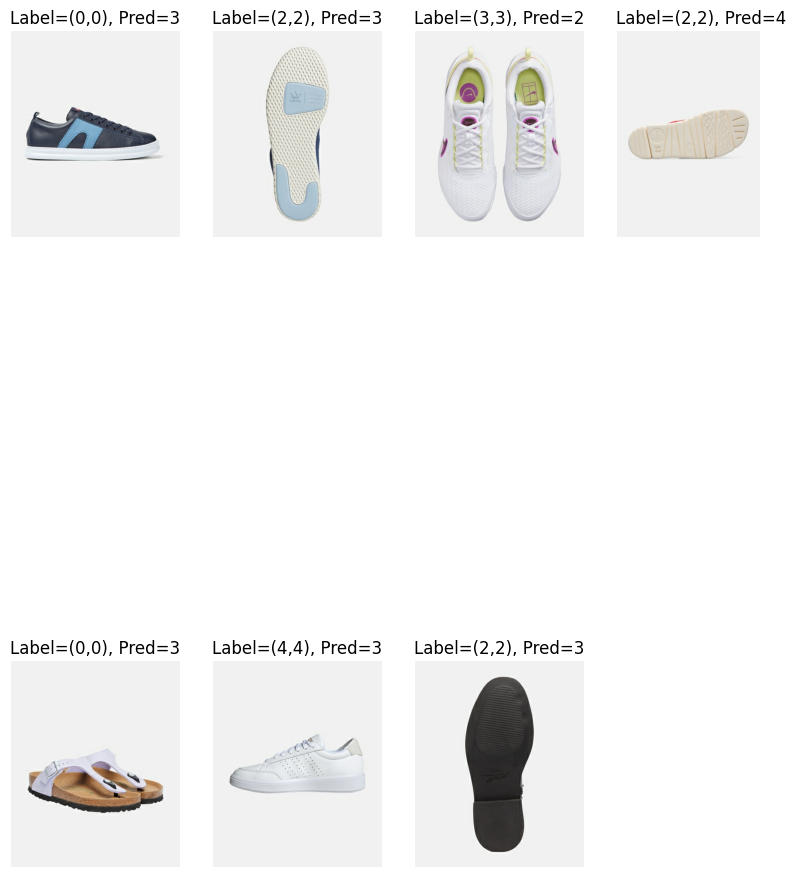

In [ ]:
import math
i=0
total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
tensor_batch = 0
plt.figure(figsize=(10, 15))
for images, labels in test_ds.take(total_tensor_batches):
  if mismatch_tensor_indexes.get(tensor_batch) is not None:
    for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
      ax = plt.subplot(math.ceil(num_mismatches/4), 4, i+1)
      plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
      plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
      plt.axis("off")
      i += 1
  tensor_batch += 1

plt.show()

In [ ]:
import math
i=0
total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
plt.figure(figsize=(15, 200))
for images, labels in test_ds.take(total_tensor_batches):
  for j in range(len(labels)):
    # print(f'{i}, {j}')
    ax = plt.subplot(math.ceil(len(y_pred)/5), 5, i + 1)
    plt.imshow(images[j].numpy().astype("uint8"))
    plt.title(f"Label={labels[j]}, Pred={y_pred[i]}")
    plt.axis("off")
    i += 1

Output hidden; open in https://colab.research.google.com to view.

## Trying to further finetune ResNet by fine_tune_epochs

In [69]:
initial_epochs = len(history_resnet.epoch)
print(initial_epochs)
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_resnet_ft2 = model_resnet.fit(train_ds,
                        epochs=total_epochs,
                        initial_epoch=history_resnet.epoch[-1],
                        validation_data=val_ds,
                        callbacks = [early_stopping_cb]
                        )

40
Epoch 40/60
24/24 [==============================] - 10s 425ms/step - loss: 0.1222 - accuracy: 0.9831 - val_loss: 0.2514 - val_accuracy: 0.9219
Epoch 41/60
24/24 [==============================] - 10s 409ms/step - loss: 0.1028 - accuracy: 0.9857 - val_loss: 0.2401 - val_accuracy: 0.9297
Epoch 42/60
24/24 [==============================] - 10s 405ms/step - loss: 0.0964 - accuracy: 0.9857 - val_loss: 0.2348 - val_accuracy: 0.9297
Epoch 43/60
24/24 [==============================] - 10s 410ms/step - loss: 0.0924 - accuracy: 0.9857 - val_loss: 0.2309 - val_accuracy: 0.9258
Epoch 44/60
24/24 [==============================] - 10s 407ms/step - loss: 0.0892 - accuracy: 0.9870 - val_loss: 0.2276 - val_accuracy: 0.9297
Epoch 45/60
24/24 [==============================] - 10s 403ms/step - loss: 0.0863 - accuracy: 0.9870 - val_loss: 0.2247 - val_accuracy: 0.9258
Epoch 46/60
24/24 [==============================] - 10s 412ms/step - loss: 0.0837 - accuracy: 0.9870 - val_loss: 0.2221 - val_accura

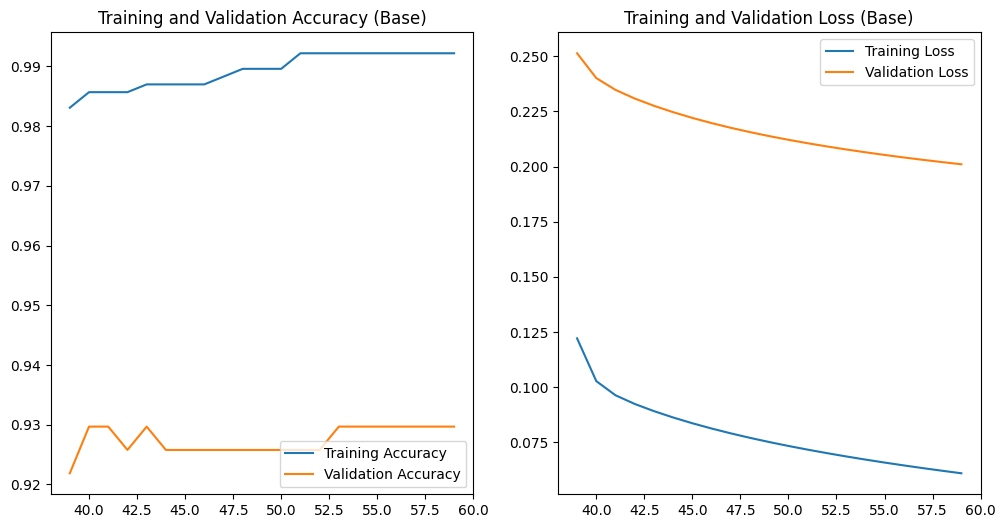

In [70]:
plot_accuracy_loss(history_resnet_ft2)

In [71]:
y_true, y_pred = eval_model_on_test(model_resnet, test_ds)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 170ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:00<00:05,  1.18it/s]

1/1 [==============================] - 0s 229ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

1/1 [==============================] - 0s 215ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:03,  1.56it/s]

1/1 [==============================] - 0s 172ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:02,  1.68it/s]

1/1 [==============================] - 0s 129ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:02<00:01,  1.84it/s]

1/1 [==============================] - 0s 86ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.01it/s]

1/1 [==============================] - 0s 85ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  2.17it/s]

1/1 [==============================] - 0s 28ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


In [53]:
print("Accuracy of ResNet50_ft2 model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of ResNet50_ft2 model on test data: 90.71%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       0.84      0.94      0.88        49
            schuhe_1_back       0.94      0.89      0.91        35
     schuhe_2_top_or_soul       0.98      0.91      0.94        46
    schuhe_3_side_to_left       0.82      0.89      0.85        45
            schuhe_4_zoom       1.00      0.90      0.95        51

                 accuracy                           0.91       226
                macro avg       0.91      0.91      0.91       226
             weighted avg       0.91      0.91      0.91       226



,0,1,2,3,4
0,46,1,0,2,0
1,3,31,0,1,0
2,0,0,42,4,0
3,4,0,1,40,0
4,2,1,0,2,46


## Trying to finetune ResNet with unlocked conv 4 and 5 blocks

In [55]:
conv_model.trainable = True
for layer in conv_model.layers:
    if(('conv5' not in layer.name) and ('conv4' not in layer.name)):
        layer.trainable = False
    if('bn' in layer.name):
        layer.trainable = False
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [57]:
model_resnet_ft_conv_4_5 = Sequential()
model_resnet_ft_conv_4_5.add(layers.Lambda(tf.keras.applications.resnet.preprocess_input, input_shape=IMG_SHAPE))
model_resnet_ft_conv_4_5.add(conv_model)
model_resnet_ft_conv_4_5.add(tf.keras.layers.GlobalAveragePooling2D())
# TODO try additional dense layer with 256 nodes
# TODO try dropout with 0.2 rate
model_resnet_ft_conv_4_5.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_resnet_ft_conv_4_5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 427, 350, 3)       0         
                                                                 
 model (Functional)          (None, 14, 11, 2048)      23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 22051845 (84.12 MB)
Non-trainable params: 1546112 (5.90 MB)
_________________________________________________________________


In [58]:
#model_resnet_ft_conv_4_5.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

# If the following error occurs when calling the fit() method, run these lines of code instead:
#KeyError: 'The optimizer cannot recognize variable conv5_block1_1_conv/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately.
#Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'
# Get the list of trainable variables
#trainable_vars = model_resnet_ft_conv_4_5.trainable_variables

# Manually build the optimizer with the list of trainable variables
#model_resnet_ft_conv_4_5.optimizer.build(trainable_vars)

# If it doesn't help:
from tensorflow.keras.optimizers.legacy import Adam as Adam_l
optimizer = Adam_l(learning_rate=learning_rate)
model_resnet_ft_conv_4_5.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

In [59]:
history_resnet_ft_conv_4_5 = model_resnet_ft_conv_4_5.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        callbacks = [early_stopping_cb]
                        )

Epoch 1/40
24/24 [==============================] - 25s 725ms/step - loss: 1.1870 - accuracy: 0.6250 - val_loss: 0.4639 - val_accuracy: 0.8633
Epoch 2/40
24/24 [==============================] - 16s 669ms/step - loss: 0.2538 - accuracy: 0.9297 - val_loss: 0.3073 - val_accuracy: 0.9102
Epoch 3/40
24/24 [==============================] - 20s 814ms/step - loss: 0.1191 - accuracy: 0.9648 - val_loss: 0.2614 - val_accuracy: 0.9141
Epoch 4/40
24/24 [==============================] - 17s 710ms/step - loss: 0.0677 - accuracy: 0.9818 - val_loss: 0.2399 - val_accuracy: 0.9219
Epoch 5/40
24/24 [==============================] - 16s 667ms/step - loss: 0.0370 - accuracy: 0.9935 - val_loss: 0.2132 - val_accuracy: 0.9375
Epoch 6/40
24/24 [==============================] - 16s 652ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.2040 - val_accuracy: 0.9414
Epoch 7/40
24/24 [==============================] - 15s 641ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.2038 - val_accuracy: 0.9414

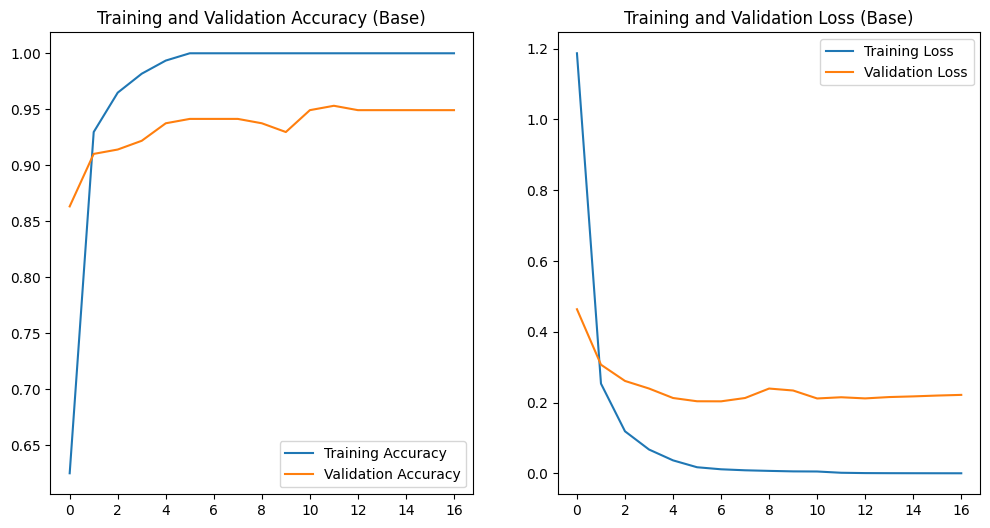

In [60]:
plot_accuracy_loss(history_resnet_ft_conv_4_5)

In [64]:
y_true, y_pred = eval_model_on_test(model_resnet_ft_conv_4_5, test_ds)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:08<00:59,  8.53s/it]

1/1 [==============================] - 0s 115ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:08<00:22,  3.77s/it]

1/1 [==============================] - 0s 236ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:09<00:11,  2.33s/it]

1/1 [==============================] - 0s 120ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:10<00:06,  1.70s/it]

1/1 [==============================] - 0s 112ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:11<00:04,  1.35s/it]

1/1 [==============================] - 0s 112ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:11<00:02,  1.04s/it]

1/1 [==============================] - 0s 116ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:12<00:00,  1.05it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:13<00:00,  1.68s/it]


In [65]:
print("Accuracy of ResNet50_ft_conv_4_5 model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of ResNet50_ft_conv_4_5 model on test data: 95.13%
                           precision    recall  f1-score   support

schuhe_0_overall_to_right       1.00      0.92      0.96        49
            schuhe_1_back       0.97      0.94      0.96        35
     schuhe_2_top_or_soul       0.98      0.96      0.97        46
    schuhe_3_side_to_left       0.91      0.93      0.92        45
            schuhe_4_zoom       0.91      1.00      0.95        51

                 accuracy                           0.95       226
                macro avg       0.95      0.95      0.95       226
             weighted avg       0.95      0.95      0.95       226



,0,1,2,3,4
0,45,1,0,2,1
1,0,33,0,0,2
2,0,0,44,2,0
3,0,0,1,42,2
4,0,0,0,0,51
